In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 765.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
# load libraries
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from supervision import Detections
from PIL import Image
from google.colab import files
import numpy as np
import torch
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.pt:   0%|          | 0.00/6.25M [00:00<?, ?B/s]

In [ ]:
#Loading face detection model
model_face = YOLO(model_path)

In [ ]:
#Loading smoke detection model
model_smoke = YOLO('/content/drive/MyDrive/Datasets/dataset_smoke/runs/detect/train/weights/best.pt')

In [ ]:
DISTANCE_THRESHOLD = 100  # Pixels

In [ ]:
def is_near(cig_box, ref_box):
    """Check if the cigarette box is near the reference box (hand or mouth)."""
    x1_c, y1_c, x2_c, y2_c = cig_box  # Cigarette bounding box
    x1_r, y1_r, x2_r, y2_r = ref_box  # Face bounding box

    # Compute the center points
    cig_center = ((x1_c + x2_c) / 2, (y1_c + y2_c) / 2)
    ref_center = ((x1_r + x2_r) / 2, (y1_r + y2_r) / 2)

    # Check if the cigarette center is within the reference box
    if x1_r <= cig_center[0] <= x2_r and y1_r <= cig_center[1] <= y2_r:
        return True
    else:
        return False

In [ ]:
def filter_cigarettes(image_path):
    """Detect cigarettes and filter based on hand/mouth proximity."""
    image = cv2.imread(image_path)

    # Run detection on the image
    cig_results = model_smoke(image)
    hand_results = model_face(image)

    # Extract detected bounding boxes
    cig_bboxes = []
    hand_bboxes = []

    # For cigarette detections:
    cig_boxes = cig_results[0].boxes.xyxy  # Bounding boxes (N, 4)
    cig_confs = cig_results[0].boxes.conf  # Confidence scores (N,)
    cig_classes = cig_results[0].boxes.cls  # Class indices (N,)

    for i, bbox in enumerate(cig_boxes):
        # bbox has 4 values: [x1, y1, x2, y2]
        x1, y1, x2, y2 = bbox.tolist()
        conf = float(cig_confs[i])
        cls = int(cig_classes[i])
        if conf > 0:  # Confidence threshold
            cig_bboxes.append((int(x1), int(y1), int(x2), int(y2)))

    # For hand/face detections:
    hand_boxes = hand_results[0].boxes.xyxy  # Bounding boxes (N, 4)
    hand_confs = hand_results[0].boxes.conf  # Confidence scores (N,)
    hand_classes = hand_results[0].boxes.cls  # Class indices (N,)

    for i, bbox in enumerate(hand_boxes):
        x1, y1, x2, y2 = bbox.tolist()
        conf = float(hand_confs[i])
        cls = int(hand_classes[i])
        if conf > 0:  # Confidence threshold
            hand_bboxes.append((int(x1), int(y1), int(x2), int(y2)))

    # Apply contextual filtering: keep only cigarettes that are near a hand/mouth region.
    valid_cigarettes = []
    for cig_box in cig_bboxes:
        if any(is_near(cig_box, hand_box) for hand_box in hand_bboxes):
            valid_cigarettes.append(cig_box)  # This cigarette is valid.

    # Draw results: green for valid detections, red for discarded ones.
    for (x1, y1, x2, y2) in valid_cigarettes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for (x1, y1, x2, y2) in cig_bboxes:
        if (x1, y1, x2, y2) not in valid_cigarettes:
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Save or display the filtered image
    cv2.imwrite("filtered_output.jpg", image)
    from google.colab.patches import cv2_imshow
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


0: 640x384 1 smoking, 1688.4ms
Speed: 4.0ms preprocess, 1688.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 FACE, 317.1ms
Speed: 4.3ms preprocess, 317.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


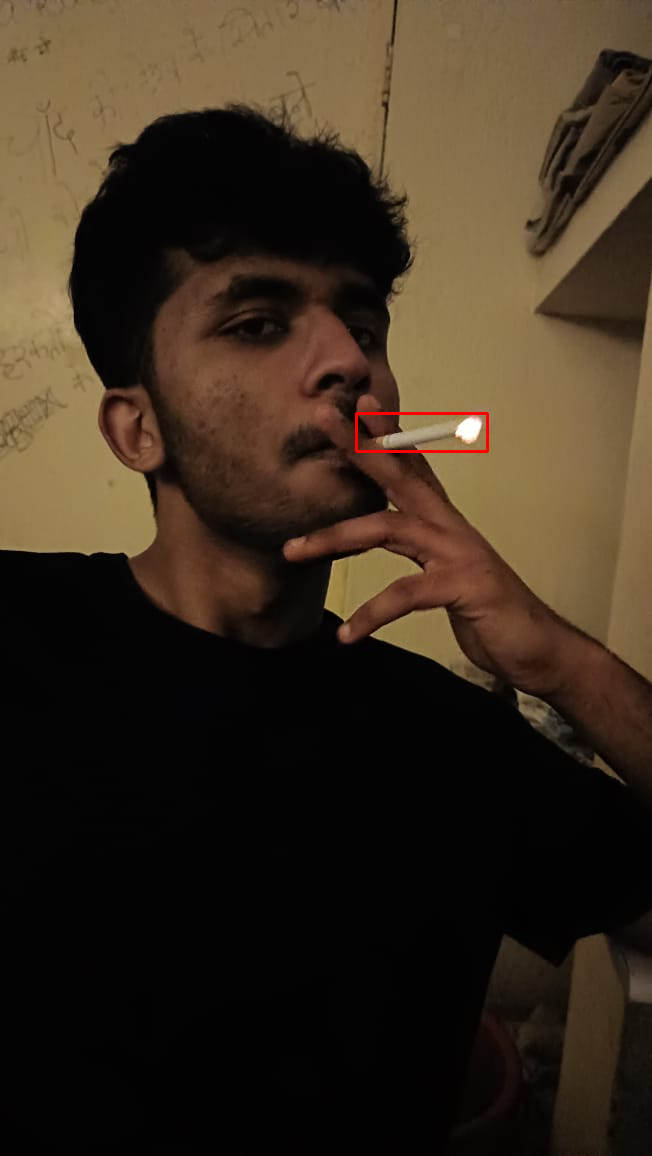

In [ ]:
filter_cigarettes("im3.jpg")

In [ ]:
import os
print(os.path.exists("smoke.jpg"))

True


In [ ]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
output = model_face(Image.open(image_path))
#results = Detections.from_ultralytics(output[0])
results = model_face.predict(source=image_path, save=True, save_txt=False)

Saving Screenshot (2).jpg to Screenshot (2).jpg

0: 416x640 1 FACE, 142.4ms
Speed: 5.8ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/Screenshot (2).jpg: 416x640 1 FACE, 145.1ms
Speed: 3.6ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict2
